In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report
from dtreeviz.trees import dtreeviz

In [2]:
df = pd.read_parquet("combined.parquet")
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)

(1640353, 89)


In [3]:
features = ["Number_of_Casualties", "CasaultyFatal_sum_sum", "CasaultySerious_sum_sum", "CasaultySlight_sum_sum", "VehTypeTwoWheeler_sum"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df["Accident_Severity"], test_size=0.25, shuffle=False
)

In [5]:
print(X_train.shape, X_test.shape)

(1230264, 5) (410089, 5)


In [6]:
rf_params = {
    "n_estimators": [10, 25, 50, 75],
    "max_depth": [2, 3, 4, 5],
    "min_samples_split": [2, 5, 8]
}

dt_params = {
    "max_depth": [2, 3, 4, 5, 6],
    "min_samples_split": [2, 5, 8],
    "min_samples_leaf": [1, 5, 10]
}

model = DecisionTreeClassifier()
ts_cv = TimeSeriesSplit(n_splits=3)
searcher = RandomizedSearchCV(
    model,
    param_distributions=dt_params,
    n_iter=25,
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=ts_cv,
    verbose=10,
    random_state=0
)
searcher.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=DecisionTreeClassifier(), n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [2, 5, 8]},
                   random_state=0, scoring='balanced_accuracy', verbose=10)

In [7]:
y_pred = searcher.best_estimator_.predict(X_test)

In [8]:
(pd.DataFrame(searcher.cv_results_)
 .drop(columns=['params', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'])
 .sort_values(by="rank_test_score").head(10))

,param_min_samples_split,param_min_samples_leaf,param_max_depth,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2,5,5,1.0,1.0,1.0,1.0,0.0,1
22,8,5,2,1.0,1.0,1.0,1.0,0.0,1
21,5,5,3,1.0,1.0,1.0,1.0,0.0,1
20,8,10,2,1.0,1.0,1.0,1.0,0.0,1
19,5,5,6,1.0,1.0,1.0,1.0,0.0,1
18,5,10,3,1.0,1.0,1.0,1.0,0.0,1
17,5,5,4,1.0,1.0,1.0,1.0,0.0,1
16,2,10,3,1.0,1.0,1.0,1.0,0.0,1
15,2,1,4,1.0,1.0,1.0,1.0,0.0,1
14,5,10,6,1.0,1.0,1.0,1.0,0.0,1


In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4683
           2       1.00      1.00      1.00     58356
           3       1.00      1.00      1.00    347050

    accuracy                           1.00    410089
   macro avg       1.00      1.00      1.00    410089
weighted avg       1.00      1.00      1.00    410089



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

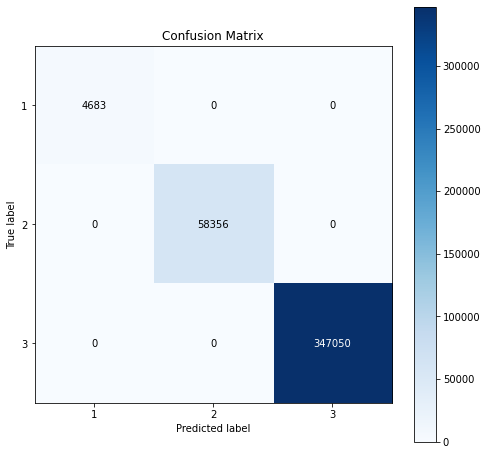

In [10]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(8, 8))

<AxesSubplot:>

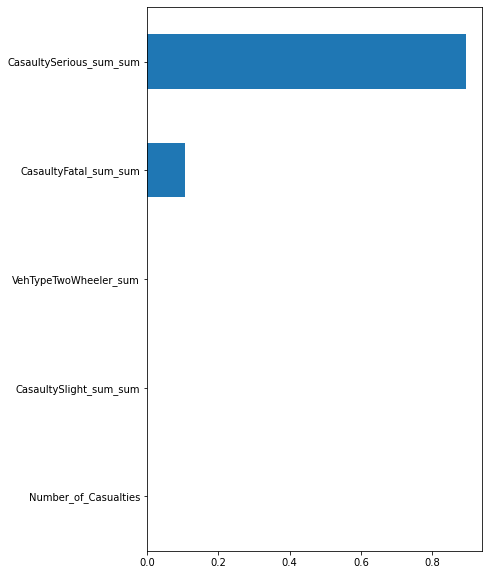

In [11]:
feat_importances = pd.Series(searcher.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=True).plot(kind='barh', figsize=(6, 10))

In [12]:
feat_importances

Number_of_Casualties       0.000000
CasaultyFatal_sum_sum      0.105412
CasaultySerious_sum_sum    0.894588
CasaultySlight_sum_sum     0.000000
VehTypeTwoWheeler_sum      0.000000
dtype: float64

[Text(418.5, 679.5, 'CasaultySerious_sum_sum <= 0.5\ngini = 0.254\nsamples = 1230264\nvalue = [16698, 163644, 1049922]'),
 Text(209.25, 407.69999999999993, 'CasaultyFatal_sum_sum <= 0.5\ngini = 0.024\nsamples = 1062944\nvalue = [13022, 0, 1049922]'),
 Text(104.625, 135.89999999999998, 'gini = 0.0\nsamples = 1049922\nvalue = [0, 0, 1049922]'),
 Text(313.875, 135.89999999999998, 'gini = 0.0\nsamples = 13022\nvalue = [13022, 0, 0]'),
 Text(627.75, 407.69999999999993, 'CasaultyFatal_sum_sum <= 0.5\ngini = 0.043\nsamples = 167320\nvalue = [3676, 163644, 0]'),
 Text(523.125, 135.89999999999998, 'gini = 0.0\nsamples = 163644\nvalue = [0, 163644, 0]'),
 Text(732.375, 135.89999999999998, 'gini = 0.0\nsamples = 3676\nvalue = [3676, 0, 0]')]

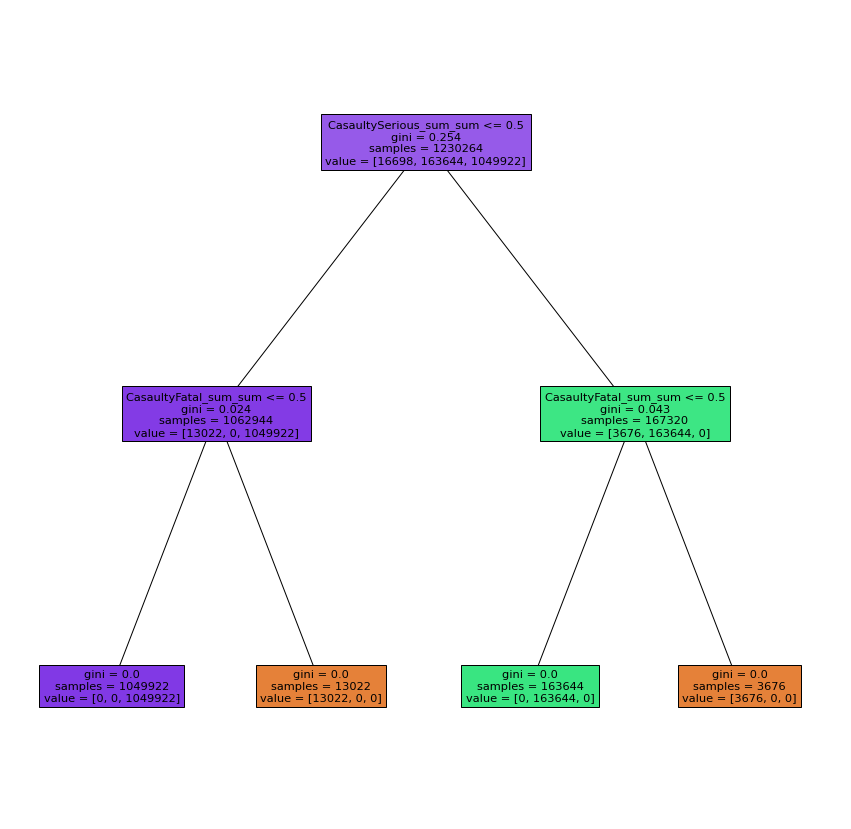

In [13]:
plt.figure(figsize=(15, 15))
plot_tree(searcher.best_estimator_, filled=True, feature_names=features)

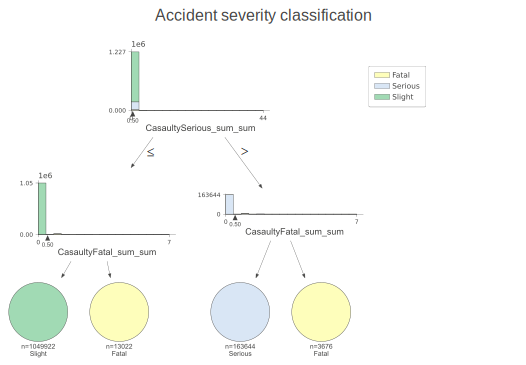

In [14]:
viz = dtreeviz(
    searcher.best_estimator_,
    X_train,
    y_train,
    feature_names=features,
    title="Accident severity classification",
    title_fontsize=16,
    class_names=["Fatal", "Serious", "Slight"]
)
viz

## Checking the rule the tree learnt

In [15]:
def severity_rule(acc):
    if acc["CasaultyFatal_sum_sum"] > 0:
        return 1
    if acc["CasaultySerious_sum_sum"] > 0:
        return 2
    if acc["CasaultySlight_sum_sum"] > 0:
        return 3
    return 0

In [16]:
relevant_df = df[["CasaultyFatal_sum_sum", "CasaultySerious_sum_sum", "CasaultySlight_sum_sum", "Accident_Severity"]].copy()
relevant_df.head()

,CasaultyFatal_sum_sum,CasaultySerious_sum_sum,CasaultySlight_sum_sum,Accident_Severity
0,0.0,0.0,1.0,3
1,0.0,0.0,1.0,3
2,0.0,0.0,1.0,3
3,0.0,0.0,1.0,3
4,0.0,0.0,1.0,3


In [17]:
relevant_df["Suspected_Accident_Severity"] = relevant_df.apply(severity_rule, axis=1)

In [18]:
relevant_df["Accident_Severity"].equals(relevant_df["Suspected_Accident_Severity"])

True